# Import dependencies

In [1]:
# import basic packages
import numpy as np
from numpy import linalg
import pandas as pd
import cvxopt
import pickle

from cvxopt.solvers import coneqp

# import thermox
import thermox
from thermox.utils import (
    handle_matrix_inputs,
    preprocess_drift_matrix,
    ProcessedDriftMatrix,
    ProcessedDiffusionMatrix,
)
from thermox.sampler import (
    sample, 
    sample_identity_diffusion
)

# import jax
from jax.scipy.linalg import solve, inv, expm
import jax
import jax.numpy as jnp
from jax import Array, random

# sklearn
from sklearn import svm    # sklearn implementation of SVMs for comparison
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs

# import utilities
import tqdm
import warnings
import time

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# warnings.filterwarnings("ignore")
# jax.config.update("jax_enable_x64", True)

# Ancillary functions

In [2]:
def linear_kernel(x1, x2):
  return np.dot(x1, x2)

def gaussian_kernel(x1, x2, sigma=1.0):
  return np.exp(-linalg.norm(x1-x2)**2 / (2 * (sigma ** 2)))

def k_max_elements(lst, k):
    indices = np.argpartition(lst, -k)[-k:]
    result = [(lst[i], i) for i in indices]
    return sorted(result, reverse=True)
    
def plot_margin(X, y, model):

    x1_min = np.min(X[:,0])
    x1_max = np.max(X[:,0])
    x2_min = np.min(X[:,1])
    x2_max = np.max(X[:,1])

    xx = np.linspace(x1_min, x1_max)

    a = -model.w[0]/model.w[1]
    yy = a*xx - (model.b)/(model.w[1])

    margin = 1 / np.sqrt(np.sum(model.w**2))
    yy_neg = yy - np.sqrt(1 + a**2) * margin
    yy_pos = yy + np.sqrt(1 + a**2) * margin

    plt.figure(figsize=(5, 5))
    plt.plot(xx, yy, "b-")
    plt.plot(xx, yy_neg, "m--")
    plt.plot(xx, yy_pos, "m--")

    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=mpl.colors.ListedColormap(colors), edgecolors="black")
    plt.xlim(0.8*x1_min, 1.2*x1_max)
    plt.ylim(0.8*x2_min, 1.2*x2_max)

    plt.axis("tight")
    plt.show()

def time_vs_dim(data, solver_params):
  times = {}
  params = {}
  models = {}
  train_error = {}
    
  times['fit_time_digital'] = np.zeros(len(data))
  times['fit_time_therm'] = np.zeros(len(data))
  
  params['digital'] = np.zeros((len(data), 3))
  params['therm'] = np.zeros((len(data), 3))

  models['digital'] = []
  models['therm'] = []

  train_error['digital'] = np.zeros(len(data))
  train_error['therm'] = np.zeros(len(data))
    
  dims = [data[i][0].shape[0] for i in range(len(data))]
  n = len(data)
  init_scales = [1] * n
    
  for i in tqdm.tqdm(range(0,n)):

    X = data[i][0]
    y = data[i][1]

    # dataset specific solver_parmas
    solver_params['init_scale'] = init_scales[i]
    
    data_size_frac = (len(data[i][0]) / len(data[0][0]))
    solver_params['num_samples'] = int(10 * data_size_frac)
      
    # solve KKT conditions using linalg package
    solver_params['solver'] = 'linalg'  
    model = SVM(kernel=linear_kernel, C=10.0, solver_params = solver_params)
    
    t0 = time.perf_counter()
    model.fit(X,y)
    t1 = time.perf_counter()
    digital_model = model

    times['fit_time_digital'][i] = model.solve_time
    
    w_digital = model.w
    b_digital = model.b

    train_error['digital'][i] = accuracy_score(y, digital_model.predict(X))
      
    # solve KKT conditions using thermox package
    solver_params['solver'] = 'therm'  
    model = SVM(kernel=linear_kernel, C=10.0,solver_params = solver_params)
      
    t0 = time.perf_counter()
    model.fit(X,y)
    t1 = time.perf_counter()
    therm_model = model
      
    times['fit_time_therm'][i] = model.solve_time
    w_therm = model.w
    b_therm = model.b
    
    train_error['therm'][i] = accuracy_score(y, therm_model.predict(X))
      
    params['digital'][i, :] = np.concatenate((w_digital, [b_digital]))
    params['therm'][i, :] = np.concatenate((w_therm, [b_therm]))
      
  return dims, times, params, train_error, digital_model, therm_model

# Custom IP algorithm

In [3]:
# custom implementation of interior point algorithm
def coneqp_custom(Q,
                  c,
                  B,
                  h,
                  A,
                  b,
                  solver_params,
                  maxiter=20,
                  alpha_0=0.5,
                  sigma=0.9,
                  eps_p=1e-6,
                  eps_d=1e-6,
                  eps_o=1e-6,
                  reg=1e-5):
    """Custom code for solving quadratic programs."""

    def primal_inf(x, A, b):
        """Compute the primal infeasibility factor."""
        return b - np.dot(A, x)

    def dual_inf(x, y, z, A, c, Q):
        """Compute the dual infeasibility factor."""
        return c - np.dot(A.T, y) - z + np.dot(Q, x)

    def update_J(J_k, x_k, z_k, reg=reg):
        J_k[n+m:, :n] = np.diag(z_k)
        J_k[n+m:, n+m:] = np.diag(x_k) + reg * np.eye(n)

    def update_v(v_k, x_k, y_k, z_k, mu_k, sigma):
        v_k[:n] = np.dot(Q, x_k) - np.dot(A.T, y_k) - z_k + c
        v_k[n:n+m] = -np.dot(A, x_k) + b
        v_k[n+m:] = -x_k * z_k + mu_k * sigma

    def potential(x_k, Q, c):
        return 0.5 * np.dot(x_k, np.dot(Q, x_k)) - np.dot(c, x_k)

    n = Q.shape[0]
    m = A.shape[0]

    init_scale = 1
    D_scale = 0.001
    dt = 5
    num_samples = solver_params['num_samples']
    burnin = solver_params['burnin']
    alpha = 0.03
    solver = solver_params['solver']
    gamma = solver_params['gamma']
    
    # Initialize variables
    init_scale = 1e-3
    x_0 = init_scale * np.ones(n) #np.linalg.lstsq(A,b)
    y_0 = np.zeros(m)
    z_0 = init_scale * np.ones(n)

    x_k = x_0
    y_k = y_0
    z_k = z_0
    mu_0 = np.dot(x_0.T, z_0) / n

    xi_p_0 = primal_inf(x_0, A, b)
    xi_d_0 = dual_inf(x_0, y_0, z_0, A, c, Q)

    # Initialize J
    start = time.time()
    solve_time = 0
    J_k = np.zeros((2 * n + m, 2 * n + m))
    J_k[:n, :n] = -Q + reg * np.eye(n)
    J_k[:n, n:n+m] = A.T
    J_k[:n, n+m:] = np.eye(n)
    J_k[n:n+m, :n] = A
    update_J(J_k, x_k, z_k, reg)

    v_k = np.zeros(J_k.shape[0])
    update_v(v_k, x_k, y_k, z_k, mu_0, sigma)

    condition = True
    k = 0
    solution = {}

    while condition:
        mu_k = sigma * mu_0

        # Update J_k and v_k

        update_J_time = time.time()
        update_J(J_k, x_k, z_k, reg)
        update_J_time = time.time() - update_J_time

        update_v_time = time.time()
        update_v(v_k, x_k, y_k, z_k, mu_k, sigma)
        update_v_time = time.time() - update_v_time

        # add initialization time for J
        init_Jv_time = time.time()
        J_k_bar = J_k.T @ J_k / 1e6
        v_k_bar = J_k.T @ v_k / 1e6
        init_Jv_time = time.time() - init_Jv_time

        if solver == 'therm' and k == 0:
            solve_time += init_Jv_time
            
        # Solve KKT system
        if solver == 'linalg':
            start_solve = time.time()
            delta_r = np.linalg.solve(J_k, v_k)
            solve_time += time.time() - start_solve
            solve_time += update_J_time + update_v_time
            
        if solver == 'therm':            
            J_k_jax = jnp.array(J_k_bar + alpha*np.eye(len(J_k)))
            v_k_jax = jnp.array(v_k_bar)

            # set A and b to jax arrays
            Am = J_k_jax 
            bm = v_k_jax 

            D =  D_scale * jnp.eye(Am.shape[0])
            key = random.PRNGKey(0)
            
            ts = jnp.arange(burnin, burnin + num_samples + 1) * dt
            ts = jnp.concatenate([jnp.array([0]), ts])
            x0 = jnp.zeros_like(bm)
            
            samples = sample(key, ts, x0, Am, jnp.linalg.solve(Am, bm), D, True) 
            delta_r = jnp.mean(samples, axis=0)

            solve_time = solve_time + (num_samples * dt * gamma) + update_J_time + update_v_time

            
            if solver_params['mute'] == False:
                delta_r_linalg = np.linalg.solve(J_k, v_k)
                print("k = " + str(k) + "        ||dr - dr*|| = " + str(jnp.linalg.norm(delta_r - delta_r_linalg)/len(delta_r)))
            
        delta_x, delta_y, delta_z = delta_r[:n], delta_r[n:n+m], delta_r[n+m:]

        # Primal step size
        alpha_p = min(alpha_0, 0.99 / (1 + np.linalg.norm(delta_x)))

        # Dual step size
        alpha_d = min(alpha_0, 0.99 / (1 + np.linalg.norm(delta_z)))

        # Update variables
        x_k += alpha_p * delta_x
        y_k += alpha_d * delta_y
        z_k += alpha_d * delta_z

        #print("alpha_p = ", alpha_p, "||x_k|| = ", np.linalg.norm(x_k), "||delta_x|| = ", np.linalg.norm(delta_x))

        xi_p_k = primal_inf(x_k, A, b)
        xi_d_k = dual_inf(x_k, y_k, z_k, A, c, Q)

        cond1_val = np.linalg.norm(xi_p_k) / (1 + np.linalg.norm(b))
        cond2_val = np.linalg.norm(xi_d_k) / (1 + np.linalg.norm(c))
        cond3_val = np.dot(x_k, z_k) / (1 + abs(potential(x_k, Q, c)))

        condition = (
            (cond1_val > eps_p) or
            (cond2_val > eps_d) or
            (cond3_val / n > eps_o)
        ) & (k < maxiter)

        #print(cond1_val, cond2_val, cond3_val)
        k += 1
    total_time = time.time() - start
    solution['x'] = x_k
    solution['total_time'] = total_time
    solution['solve_time'] = solve_time

    return solution

# Custom implementation of SVM

In [4]:
class SVM(object):

  def __init__(self, kernel = linear_kernel, C = None, solver_params = None):
    self.kernel = kernel
    self.C = C
    self.solver_params = solver_params
    self.solution = None
    self.fitting_sols = []
      
  # Train model using dataset (X, y)
  def fit(self, X, y):
    n_samples, n_features = X.shape
    solver = self.solver_params['solver']
      
    # Define Gram matrix using the kernel
    G = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
      for j in range(n_samples):
          G[i,j] = self.kernel(X[i], X[j])

    if solver == "cvxopt":
      Q = cvxopt.matrix(np.outer(y,y) * G)
      c = cvxopt.matrix(-1 * np.ones(n_samples))
      A = cvxopt.matrix(y, (1,n_samples))
      b = cvxopt.matrix(0.0)
    else:
      Q = np.outer(y,y) * G
      c = -1 * np.ones(n_samples)
      A = y.reshape(1,n_samples)
      b = 0.0

      # Hard SVM model (positivity constraint)
    if self.C is None:
      if solver == "cvxopt":
        B = cvxopt.matrix(np.diag(-1 * np.ones(n_samples)))
        h = cvxopt.matrix(np.zeros(n_samples))
      else:
        B = np.diag(-1 * np.ones(n_samples))
        h = np.zeros(n_samples)
    
    # Soft SVM model  (positivity constraint + nonzero error constraint)
    else:
      if solver == "cvxopt":
        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        B = cvxopt.matrix(np.vstack((tmp1, tmp2)))
        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * self.C
        h = cvxopt.matrix(np.hstack((tmp1, tmp2)))
      else:
        tmp1 = np.diag(np.ones(n_samples) * -1)
        tmp2 = np.identity(n_samples)
        B = np.vstack((tmp1, tmp2))
        tmp1 = np.zeros(n_samples)
        tmp2 = np.ones(n_samples) * self.C
        h = np.hstack((tmp1, tmp2))

    # Solve QP problem
    if solver == "cvxopt":
      solution = coneqp(Q, c, B, h, None, A, b)
    else:
      solution = coneqp_custom(Q, c, B, h, A, b, solver_params)
      
      self.solve_time = solution['solve_time']
      self.total_time = solution['total_time']
      self.solution = solution 
        
    # Lagrange multipliers
    a = np.ravel(solution['x'])

    # Support vectors have non zero lagrange multipliers
    S = (a > 1e-5).flatten()
      
    # Extract support vectors
    self.a = a[S]
    self.sv = X[S]
    self.sv_y = y[S]
      
    # Weight vector
    if self.kernel == linear_kernel:
      self.w = np.zeros(n_features)
      for n in range(len(self.a)):
        self.w += self.a[n] * self.sv_y[n] * self.sv[n]
    else:
      self.w = None

    # Intercept
    self.b = np.mean(y[S] - np.dot(X[S], (self.w).reshape(-1,1)))

    self.fitting_sols = np.append(self.fitting_sols, solution['x'])
      
  # Predict the class of data points X
  def predict(self, X):
    if self.w is not None:
      projection = np.dot(X, self.w) + self.b
    else:
      y_predict = np.zeros(len(X))
      for i in range(len(X)):
        s = 0
        for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
          s += a * sv_y * self.kernel(X[i], sv)
        y_predict[i] = s

      projection = y_predict + self.b

    return np.sign(projection)

# Choose dataset

In [5]:
cancer = load_breast_cancer()
df_cancer = pd.DataFrame(np.c_[cancer['data'],cancer['target']], columns = np.append(cancer['feature_names'],['target']))
pd.option_context('mode.use_inf_as_na', True)
df_cancer.replace([np.inf, -np.inf], np.nan, inplace=True)

feature1 = 'mean radius'
feature2 = 'mean smoothness'

X = df_cancer[[feature1, feature2]].to_numpy()
y = df_cancer['target'].to_numpy()
y = np.array([-1.0 if x == 0 else x for x in y]).reshape(len(y), 1)

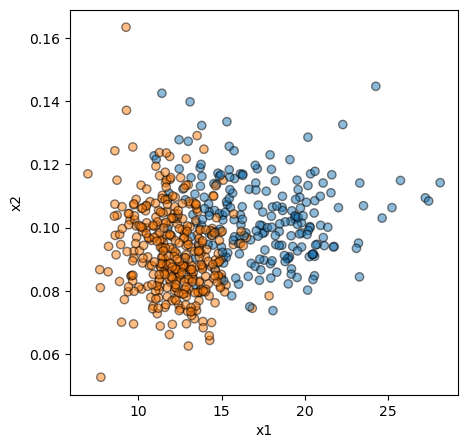

In [6]:
colors = [sns.color_palette()[0], sns.color_palette()[1]]

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=mpl.colors.ListedColormap(colors), edgecolors="black")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

### Add redundancy to increase dataset size

In [7]:
X1 = X

X_rnd = np.abs(np.random.normal(0,0.01, size = X.shape))
X2 = X + np.multiply(X, X_rnd)

X_rnd = np.abs(np.random.normal(0,0.01, size = X.shape))
X3 = X + np.multiply(X, X_rnd)

X_rnd = np.abs(np.random.normal(0,0.01, size = X.shape))
X4 = X + np.multiply(X, X_rnd)

X_rnd = np.abs(np.random.normal(0,0.01, size = X.shape))
X5 = X + np.multiply(X, X_rnd)

In [8]:
X = np.concatenate((X1, X2, X3, X4))
y = np.concatenate((y, y, y, y))

len(X)

2276

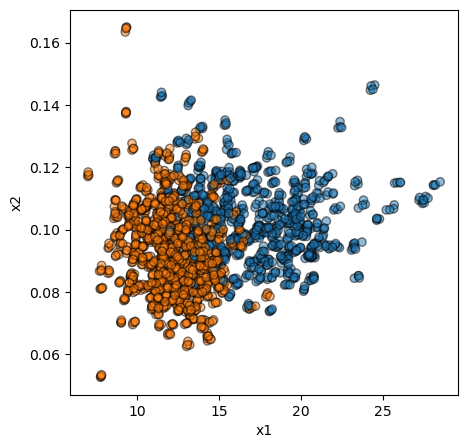

In [9]:
colors = [sns.color_palette()[0], sns.color_palette()[1]]

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=mpl.colors.ListedColormap(colors), edgecolors="black")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [10]:
# Divide dataset into batches 
num_batches = 6
batch_size = int(len(X)/num_batches)
data = []

for i in range(0, num_batches):
   start_ind = 0
   end_ind = (i+1)*batch_size
   new_data = (X[start_ind:end_ind, :], y[start_ind:end_ind])
   data.append(new_data)

# Test QP SVM solvers

In [96]:
# general solver parameters
solver_params = {}

solver_params['D_scale'] = 0.001
solver_params['dt']  = 10
solver_params['num_samples'] = 10 # num_smaples per n
solver_params['burnin'] = 0
solver_params['alpha'] = 0.05
solver_params['init_scale'] = 5
solver_params['solver'] = 'linalg'
solver_params['gamma'] = 1e-3

solver_params['mute'] = True

### Digital (linalg package)

In [99]:
X, y = data[2]

digital_model = SVM(kernel=linear_kernel, C=10,solver_params=solver_params)
digital_model.fit(X,y)

In [ ]:
plot_margin(X, y, digital_model)
accuracy_score(y, digital_model.predict(X))

### Thermodynamic (thermox package)

In [70]:
solver_params['solver'] = 'therm'

therm_model = SVM(kernel=linear_kernel, C=10.0, solver_params = solver_params)

therm_model.fit(X,y)

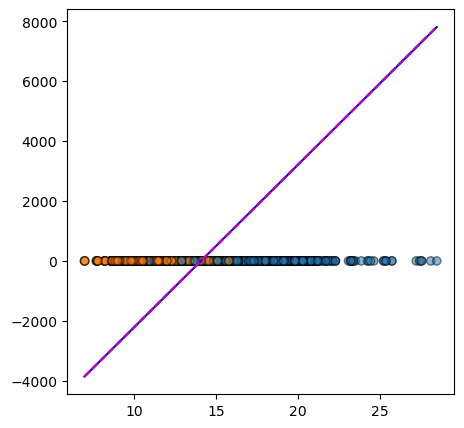

0.8536776212832551

In [71]:
plot_margin(X, y, therm_model)
accuracy_score(y, therm_model.predict(X))

In [72]:
accuracy_score(y, therm_model.predict(X)) - accuracy_score(y, digital_model.predict(X))

0.032863849765258246

In [73]:
S_therm = (therm_model.fitting_sols > 1e-5).flatten()
a_therm = therm_model.fitting_sols

In [74]:
print(therm_model.w / therm_model.w[0])
print(therm_model.b / therm_model.w[0])

[ 1.         -0.00184154]
-14.089001166885962


In [75]:
print(digital_model.w / digital_model.w[0])
print(digital_model.b / digital_model.w[0])

[1.         0.00412486]
-16.538925414153415


# Run thermodynamic solver on batches

In [98]:
solver_params['mute'] = True
solver_params['gamma'] = 1e-3

# compute times
dims, times, params, train_errors, digital_model, therm_model = time_vs_dim(data, solver_params)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [49:17<00:00, 492.99s/it]


### Plotting

In [32]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 100, 80

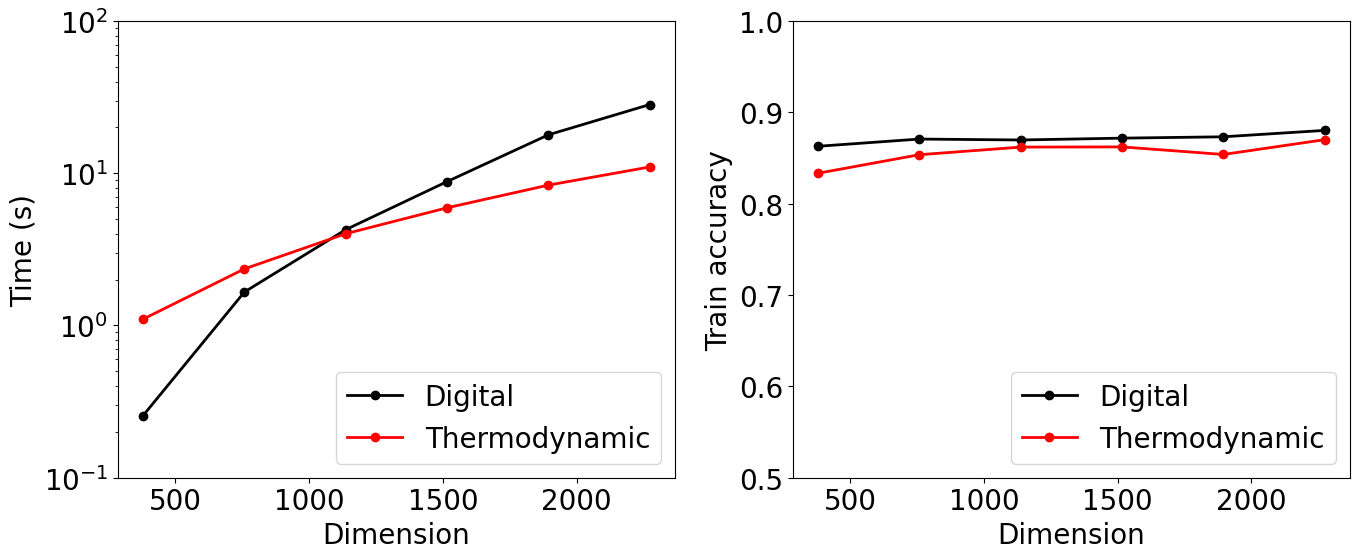

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,6))

ax1.plot(dims, times['fit_time_digital'], label="Digital", color="black", marker='o', lw=2)
ax1.plot(dims, times['fit_time_therm'], label="Thermodynamic", color="red", marker='o', lw=2)
ax1.legend(loc=4)
ax1.set_xlabel("Dimension")
ax1.set_ylabel("Time (s)")
ax1.set_yscale('log')
# ax1.set_xscale('log')
ax1.set_ylim(1e-1,1e2)

ax2.plot(dims, train_errors['digital'], label="Digital", color="black", marker='o', lw=2)
ax2.plot(dims, train_errors['therm'], label="Thermodynamic", color="red", marker='o', lw=2)
ax2.legend(loc=4)
ax2.set_xlabel("Dimension")
ax2.set_ylabel("Train accuracy")
#ax1.set_yscale('log')
# ax2.set_xscale('log')
ax2.set_ylim(0.5,1)

# plt.show()
fig.tight_layout()
plt.savefig('plot.pdf')

In [102]:
# error in normalized parameters
normalized_params_digital = np.array([params['digital'][i] / params['digital'][i][0] for i in range(0, len(params['digital']))])
normalized_params_therm = np.array([params['therm'][i] / params['therm'][i][0] for i in range(0, len(params['therm']))])

(-20.0, -10.0)

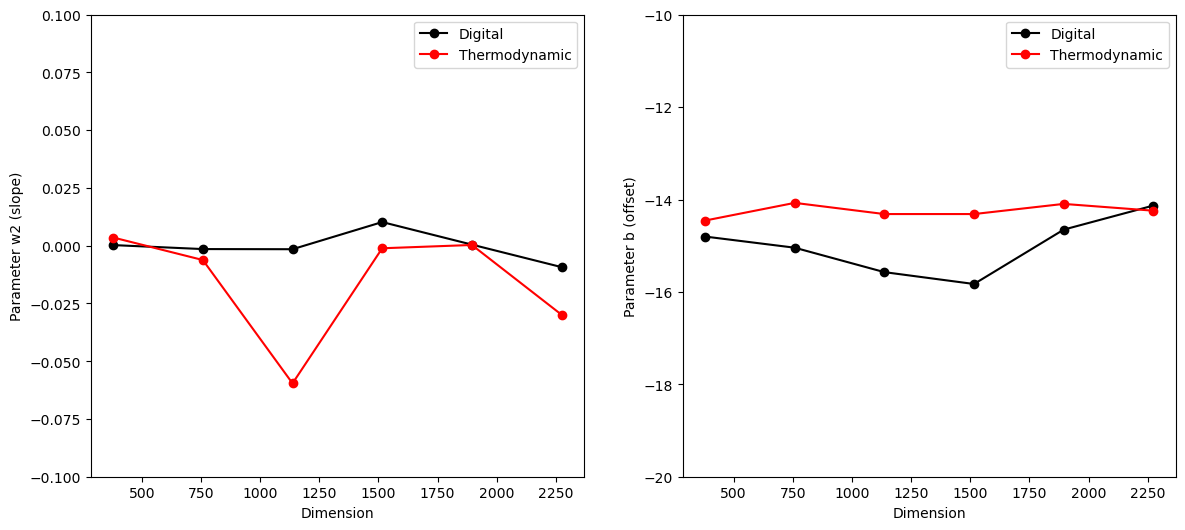

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,6))

ax1.plot(dims, normalized_params_digital[:,1], label="Digital", color="black", marker='o')
ax1.plot(dims, normalized_params_therm[:,1], label="Thermodynamic", color="red", marker='o')
ax1.legend()
ax1.set_xlabel("Dimension")
ax1.set_ylabel("Parameter w2 (slope)")
ax1.set_ylim(-0.1,0.1)

ax2.plot(dims, normalized_params_digital[:,2], label="Digital", color="black", marker='o')
ax2.plot(dims, normalized_params_therm[:,2], label="Thermodynamic", color="red", marker='o')
ax2.legend()
ax2.set_xlabel("Dimension")
ax2.set_ylabel("Parameter b (offset)")
ax2.set_ylim(-20,-10)